In [1]:
import pickle
import os
from tqdm import tqdm
from gensim.models import Word2Vec
import numpy as np
from tensorflow.keras.utils import Sequence
import gc
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense , Lambda , Reshape , MaxPooling1D, Layer ,Conv1D, UpSampling1D, Conv1D , Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras import metrics
import numpy as np

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

unable to import 'smart_open.gcs', disabling that module


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [106]:
import hashlib

def get_latent_vec(model , SAVEPATH, filenames):
    result = []
    for filename in tqdm(filenames):
        data = load_pickle(filename)
        vec = model.predict(np.array([data])).reshape(16)
        md5 = hashlib.md5(str(vec).encode()).hexdigest()
        result.append([md5,vec])
        
    with open(os.path.join(SAVEPATH,'latent_vec2.pickle'),'wb') as f:
        pickle.dump(result,f,protocol=4)
    return result

In [3]:
def get_edit_cosine(result_dic):
    x_data = []
    y_data = []
    sorted_dic = sorted(result_dic.items() , key=lambda x:x[0])
    for i in sorted_dic:
        x_data.append(i[0])
        y_data.append(i[1])
    return x_data , y_data , sorted_dic

In [69]:
def load_pickle(filename):
    with open(filename , 'rb') as f:
        return pickle.load(f)


In [5]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

In [6]:
class DataSequence(Sequence):
    def __init__(self, x_set, batch_size, shuffle=True):
        self.x = x_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, fn_list):
        data_files = []
        for fn in fn_list:
            try:
                with open(fn , 'rb') as f:
                    data_files.append(pickle.load(f))
            except:
                with open('error_pickles.txt','a') as f:
                    f.write(fn + '\n')
        data_files = np.array(data_files)
        return data_files
    
    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_x = self.__data_generation(self.x[indexes])
        #print(batch_x.shape)
        return batch_x, batch_x

In [7]:
with open('edit_dic.pickle','rb') as f:
    dicc = pickle.load(f)

In [78]:
fn_list = []
BASEPATH = r'E:\benn4_conv'
for dirpath, dirnames, filenames in os.walk(BASEPATH):
    for filename in filenames:
        fn_list.append(os.path.join(dirpath,filename))
print(len(fn_list))

 

5147572


In [87]:
img_shape = (32, 64)
latent_dim = 16

input_img = Input(shape=img_shape)
x = Conv1D(64, 3, activation='relu', padding='same')(input_img)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)

shape_before_flattening = K.int_shape(x)

x = Flatten()(x)

latent_vector = Dense(latent_dim,activation='sigmoid')(x)

x = Dense(np.prod(shape_before_flattening[1:]),activation='relu')(latent_vector)
x = Reshape(shape_before_flattening[1:])(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(64, 3, activation='sigmoid', padding='same')(x)

In [88]:
encoder = Model(input_img, latent_vector)
encoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 64)]          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 32, 64)            12352     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16, 32)            6176      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 8, 16)             1552      
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0   

In [89]:
autoencoder = Model(input_img, x)
autoencoder.compile(optimizer='adam', loss = 'binary_crossentropy', experimental_run_tf_function=False)
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 64)]          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 32, 64)            12352     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16, 32)            6176      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 8, 16)             1552      
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0   

In [90]:
train_generator = DataSequence(np.array(fn_list), 8192)

In [91]:
autoencoder.fit(train_generator,
        epochs=16,
        verbose=1)

Epoch 1/16
629/629 [==============================] - 2220s 4s/step - loss: 0.6694
Epoch 2/16
629/629 [==============================] - 2090s 3s/step - loss: 0.6663
Epoch 3/16
629/629 [==============================] - 2089s 3s/step - loss: 0.6661
Epoch 4/16
629/629 [==============================] - 2096s 3s/step - loss: 0.6659
Epoch 5/16
629/629 [==============================] - 1993s 3s/step - loss: 0.6658
Epoch 6/16
629/629 [==============================] - 2023s 3s/step - loss: 0.6657
Epoch 7/16
629/629 [==============================] - 2010s 3s/step - loss: 0.6656
Epoch 8/16
629/629 [==============================] - 1986s 3s/step - loss: 0.6655
Epoch 9/16
629/629 [==============================] - 2000s 3s/step - loss: 0.6654
Epoch 10/16
629/629 [==============================] - 1943s 3s/step - loss: 0.6654
Epoch 11/16
629/629 [==============================] - 1994s 3s/step - loss: 0.6653
Epoch 12/16
629/629 [==============================] - 1976s 3s/step - loss: 0.6653
E

In [92]:
model_json = encoder.to_json()
with open("conv_encoder_0511.json", "w") as json_file : 
    json_file.write(model_json)

encoder.save_weights("conv_encoder_0511.h5")
print("Saved lstm_model to disk0511")

Saved lstm_model to disk0511


In [93]:
img_shape = (64, 64)
latent_dim = 16

input_img = Input(shape=img_shape)
x = Conv1D(64, 3, activation='relu', padding='same')(input_img)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)

shape_before_flattening = K.int_shape(x)

x = Flatten()(x)

latent_vector = Dense(latent_dim,activation='sigmoid')(x)

x = Dense(np.prod(shape_before_flattening[1:]),activation='relu')(latent_vector)
x = Reshape(shape_before_flattening[1:])(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(64, 3, activation='sigmoid', padding='same')(x)

encoder = Model(input_img, latent_vector)
encoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64)]          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 64, 64)            12352     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 32, 64)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 32, 32)            6176      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 16, 32)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16, 16)            1552      
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0   

In [94]:
autoencoder = Model(input_img, x)
autoencoder.compile(optimizer='adam', loss = 'binary_crossentropy', experimental_run_tf_function=False)
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64)]          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 64, 64)            12352     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 32, 64)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 32, 32)            6176      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 16, 32)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16, 16)            1552      
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0   

In [95]:
fn_list = []
BASEPATH = r'E:\benn5_conv'
for dirpath, dirnames, filenames in os.walk(BASEPATH):
    for filename in filenames:
        fn_list.append(os.path.join(dirpath,filename))
print(len(fn_list))

 

3888710


In [96]:
train_generator = DataSequence(np.array(fn_list), 8192)

In [97]:
autoencoder.fit(train_generator,
        epochs=16,
        verbose=1)

Epoch 1/16
475/475 [==============================] - 2671s 6s/step - loss: 0.6690
Epoch 2/16
475/475 [==============================] - 2704s 6s/step - loss: 0.6657
Epoch 3/16
475/475 [==============================] - 2667s 6s/step - loss: 0.6655
Epoch 4/16
475/475 [==============================] - 2748s 6s/step - loss: 0.6653
Epoch 5/16
475/475 [==============================] - 2602s 5s/step - loss: 0.6652
Epoch 6/16
475/475 [==============================] - 2538s 5s/step - loss: 0.6652
Epoch 7/16
475/475 [==============================] - 2663s 6s/step - loss: 0.6651
Epoch 8/16
475/475 [==============================] - 2504s 5s/step - loss: 0.6650
Epoch 9/16
475/475 [==============================] - 2660s 6s/step - loss: 0.6650
Epoch 10/16
475/475 [==============================] - 2562s 5s/step - loss: 0.6649
Epoch 11/16
475/475 [==============================] - 2482s 5s/step - loss: 0.6649
Epoch 12/16
475/475 [==============================] - 2659s 6s/step - loss: 0.6649
E

In [98]:
model_json = encoder.to_json()
with open("conv_encoder_0511_64.json", "w") as json_file : 
    json_file.write(model_json)

encoder.save_weights("conv_encoder_0511_64.h5")
print("Saved lstm_model to disk0511_64")

Saved lstm_model to disk0511_64


In [21]:
result_dic = {}
for i in (dicc):
    datas = dicc[i]
    split_data = datas[:1000]
    size = len(split_data)
    total = 0
    for data in tqdm(split_data):
        data1 = load_pickle(data[0])
        pre_1 = encoder.predict(np.array([data1])).reshape(16)

        data2 = load_pickle(data[1])
        pre_2 = encoder.predict(np.array([data2])).reshape(16)
        total += cos_sim(pre_1,pre_2)
    print(i,total,size)
    result_dic[i] = total/size
#         print('index : ',i,'cos : ',cos_sim(pre_1,pre_2))
        

  0%|▏                                                                                | 3/1000 [00:00<00:33, 29.83it/s]

0 32.99999958276749 33


  0%|▎                                                                                | 4/1000 [00:00<00:29, 33.23it/s]

15 911.6808377504349 1000


  0%|▎                                                                                | 4/1000 [00:00<00:27, 36.52it/s]

16 889.095743060112 1000


  0%|▏                                                                                | 3/1000 [00:00<00:33, 29.56it/s]

11 930.4196940660477 1000


  0%|▎                                                                                | 4/1000 [00:00<00:28, 35.00it/s]

12 926.9788753986359 1000


  0%|▎                                                                                | 4/1000 [00:00<00:28, 35.19it/s]

14 914.6493907570839 1000


  0%|▎                                                                                | 4/1000 [00:00<00:30, 32.22it/s]

13 919.5231069922447 1000


  0%|▎                                                                                | 4/1000 [00:00<00:29, 33.79it/s]

9 967.0284911990166 1000


  0%|▎                                                                                | 4/1000 [00:00<00:27, 36.14it/s]

10 936.3477792143822 1000


  0%|▎                                                                                | 4/1000 [00:00<00:33, 29.85it/s]

8 983.5430095791817 1000


  0%|▎                                                                                | 4/1000 [00:00<00:30, 32.53it/s]

7 980.7621728181839 1000


 10%|████████▎                                                                          | 4/40 [00:00<00:00, 36.79it/s]

6 978.543732881546 1000


  2%|█▏                                                                                | 4/265 [00:00<00:07, 32.88it/s]

3 39.61249387264252 40


  0%|▏                                                                                | 3/1000 [00:00<00:41, 23.80it/s]

4 260.54302674531937 265


 15%|████████████▍                                                                      | 3/20 [00:00<00:00, 29.57it/s]

5 976.9776102900505 1000


  6%|████▌                                                                              | 3/54 [00:00<00:01, 29.77it/s]

2 19.84092539548874 20


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 32.77it/s]

1 53.91352266073227 54


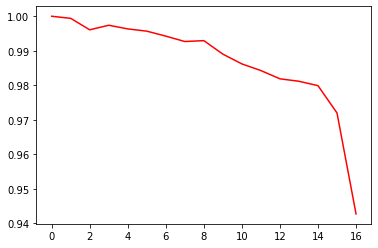

In [30]:
import matplotlib.pyplot as plt
plt.plot(x_data1,y_data1,color='red')
plt.plot(x_data2 , y_data2 ,color='blue')
plt.show()

In [35]:
x_data2 , y_data2 , sorted_dic2 = get_edit_cosine(result_dic)

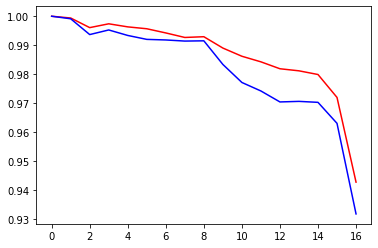

In [38]:
plt.plot(x_data1,y_data1,color='red')
plt.plot(x_data2 , y_data2 ,color='blue')
plt.show()

In [43]:
x_data3 , y_data3 , sorted_dic3 = get_edit_cosine(result_dic)

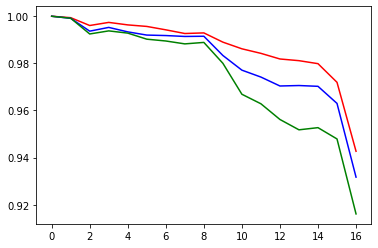

In [44]:
plt.plot(x_data1,y_data1,color='red')#1
plt.plot(x_data2 , y_data2 ,color='blue')#2
plt.plot(x_data3 , y_data3 ,color='green')#4
plt.show()

In [48]:
x_data4 , y_data4 , sorted_dic4 = get_edit_cosine(result_dic)

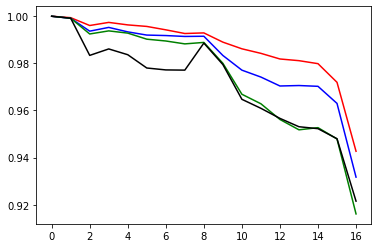

In [49]:
plt.plot(x_data1,y_data1,color='red')#1
plt.plot(x_data2 , y_data2 ,color='blue')#2
plt.plot(x_data3 , y_data3 ,color='green')#4
plt.plot(x_data4 , y_data4 ,color='black')#9
plt.show()

In [76]:
x_data5 , y_data5 , sorted_dic5 = get_edit_cosine(result_dic)

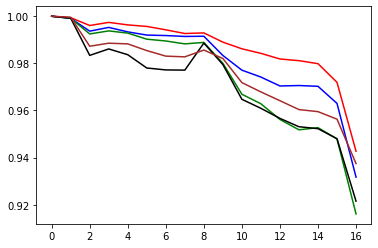

In [78]:
plt.plot(x_data1,y_data1,color='red')#1
plt.plot(x_data2 , y_data2 ,color='blue')#2
plt.plot(x_data3 , y_data3 ,color='green')#4
plt.plot(x_data4 , y_data4 ,color='black')#9
plt.plot(x_data5 , y_data5 ,color='brown')#20
plt.show()